In [1]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests
from utilities import query, query_list


from sodapy import Socrata
import sqlalchemy as db

**Connect to Database**

In [2]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [3]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [4]:
df = query('SELECT * FROM con_bills.current_bills WHERE Cong >= 110')


**Review All data**

Important coding:
    
- Party: (100 Democrat; 200 Republican, 328…from ICPSR)
- Cosponsor: Number of cosponsors
    

In [5]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassH,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...


In [6]:
df.shape

(51067, 29)

In [7]:
#Review the dependent variable counts
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51067 entries, 0 to 51066
Data columns (total 29 columns):
BillID      51067 non-null object
BillType    51067 non-null object
Chamber     51067 non-null int64
Cong        51067 non-null int64
Cosponsr    51067 non-null float64
IntrDate    51025 non-null object
Mult        51067 non-null int64
PLaw        51067 non-null int64
Title       51067 non-null object
Veto        51067 non-null int64
Class       51067 non-null float64
District    51067 non-null float64
FrstConH    51067 non-null float64
FrstConS    51067 non-null float64
Gender      51067 non-null int64
MRef        51067 non-null int64
NameFull    51067 non-null object
Party       51067 non-null float64
Postal      51067 non-null object
PassH       51067 non-null int64
PassS       51067 non-null int64
PLawDate    1393 non-null object
PLawNum     51067 non-null object
ImpBill     51067 non-null int64
Majority    51067 non-null int64
Major       51067 non-null float64
Minor       

**Combined Text:**

In [9]:
df['combined_text'] = df[['Title', 'Summary']].astype(str).apply(' '.join, axis=1)

In [10]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PassS,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...


In [11]:
df.iloc[555][8]
df.iloc[555][28]

'Short Sea Shipping Promotion Act of 2007 - Amends the Internal Revenue Code to exempt from the harbor maintenance tax cargo contained in intermodal cargo containers and loaded by crane on a vessel, or cargo loaded on a vessel by means of wheeled technology, that is: (1) loaded at a U.S. port and unloaded at another U.S. port or a port in Canada located in the Great Lakes Saint Lawrence Seaway System; or (2) loaded at a port in Canada located in the Great Lakes Saint Lawrence Seaway System and unloaded at a U.S. port.'

In [12]:
new = df[['PassH', 'combined_text', 'Cong', 'BillID']].copy()

In [13]:
new.head()

,PassH,combined_text,Cong,BillID
0,1,To provide for the implementation of the recom...,110,110-HR-1
1,0,Reserved for Speaker.,110,110-HR-10
2,0,To amend the Higher Education Act of 1965 to p...,110,110-HR-100
3,0,To award a congressional gold medal to Edward ...,110,110-HR-1000
4,0,To amend the Haitian Hemispheric Opportunity t...,110,110-HR-1001


In [14]:
passed_only = new.loc[new['PassH'] != 0] 

print(len(passed_only))
passed_only.head()

4025


,PassH,combined_text,Cong,BillID
0,1,To provide for the implementation of the recom...,110,110-HR-1
6,1,To amend the Foreign Affairs Reform and Restru...,110,110-HR-1003
9,1,To amend the provisions of law relating to the...,110,110-HR-1006
15,1,To designate additional National Forest System...,110,110-HR-1011
18,1,"To amend the Federal Food, Drug, and Cosmetic ...",110,110-HR-1014


In [15]:
passed_only.iloc[6][1]

'To direct the Secretary of the Interior to conduct a special resources study regarding the suitability and feasibility of designating certain historic buildings and areas in Taunton, Massachusetts, as a unit of the National Park System, and for other purposes. (This measure has not been amended since it was introduced. The summary has been expanded because action occurred on the measure.)'

**Basic NLP EDA:**

In [16]:
df['Summary'].isnull().sum()

50

In [17]:
df['text_len'] = [len(summary) for summary in df['combined_text']]

In [18]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PLawDate,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,combined_text,text_len
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,2007-08-03 00:00:00,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,To provide for the implementation of the recom...,331
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,None,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,Reserved for Speaker.,22
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,None,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,To amend the Higher Education Act of 1965 to p...,720
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,None,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,To award a congressional gold medal to Edward ...,400
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,None,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,To amend the Haitian Hemispheric Opportunity t...,575


In [19]:
df.groupby(['PassH','Cong'])['text_len'].agg('median')

PassH  Cong
0      110     515.0
       111     527.0
       112     487.0
       113     554.0
       114     223.0
1      110     450.0
       111     380.0
       112     355.0
       113     345.5
       114     278.0
Name: text_len, dtype: float64

In [20]:
#Median text length by congress, passed or didn't pass
df.groupby(['PLaw','Cong'])['text_len'].agg('median')

PLaw  Cong
0     110     514.0
      111     525.0
      112     486.0
      113     550.0
      114     226.0
1     110     395.5
      111     329.5
      112     310.5
      113     300.0
      114     299.0
Name: text_len, dtype: float64

In [45]:
df['title_len'] = [len(summary) for summary in df['Title']]

In [46]:
#Median Bill Title length by congress, passed or didn't pass
df.groupby(['PLaw','Cong'])['title_len'].agg('median')

PLaw  Cong
0     110     151.0
      111     154.0
      112     139.0
      113     157.0
      114     158.0
1     110     197.5
      111     186.0
      112     178.0
      113     169.0
      114     175.0
Name: title_len, dtype: float64

**Basic Feature Info:**

In [21]:
df['Cong'].value_counts()

110    11081
111    10629
112    10436
114    10055
113     8866
Name: Cong, dtype: int64

In [22]:
df['Cong'].value_counts()

110    11081
111    10629
112    10436
114    10055
113     8866
Name: Cong, dtype: int64

In [23]:
df['BillType'].value_counts()

hr    33016
s     18051
Name: BillType, dtype: int64

**General Visualizations:**

In [24]:
import seaborn as sns
sns.set(style="whitegrid")

df['PassH'].value_counts().plot.barh().set_title('Passed vs. Proposed Bills')

Text(0.5, 1.0, 'Passed vs. Proposed Bills')

Text(0.5, 1.0, 'Bills Proposed by Chamber')

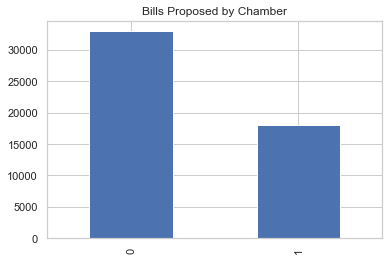

In [25]:
df['Chamber'].value_counts().plot.bar().set_title('Bills Proposed by Chamber')

Text(0.5, 1.0, 'Number of Bills by Recent Congress')

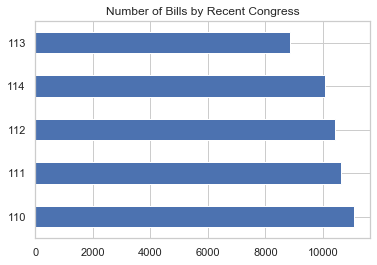

In [26]:
df['Cong'].value_counts().plot.barh().set_title('Number of Bills by Recent Congress')


Text(0.5, 1.0, 'Majority vs Minority House Bill Proposals')

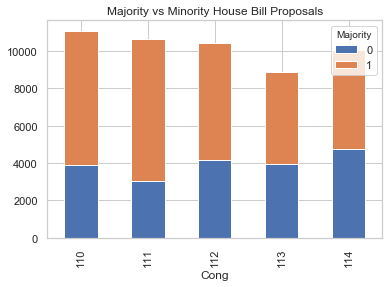

In [27]:
#Bills Proposed by Majority or Not, for all Congresses
#DONT USE< DOESNT REALLY MAKE SENSE

df.groupby(['Cong', 'Majority']).size().unstack().plot.bar(stacked=True).set_title('Majority vs Minority House Bill Proposals')


Text(0.5, 1.0, 'Bill Passage in House per Congress')

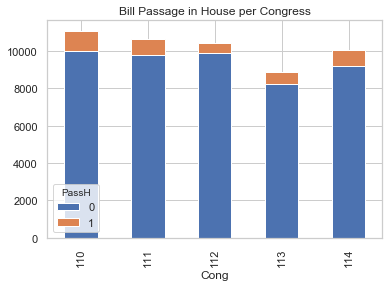

In [28]:
#Portion of bills proposed for all congresses vs those that passed the house 
df.groupby(['Cong', 'PassH']).size().unstack().plot.bar(stacked=True).set_title('Bill Passage in House per Congress')


Text(0.5, 1.0, 'Bill Passage Senate per Congress')

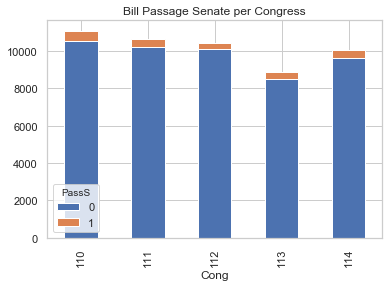

In [29]:
#Portion of bills proposed for all congresses vs those that passed the house 
df.groupby(['Cong', 'PassS']).size().unstack().plot.bar(stacked=True).set_title('Bill Passage Senate per Congress')


Text(0.5, 1.0, 'Bill Proposal by Chamber')

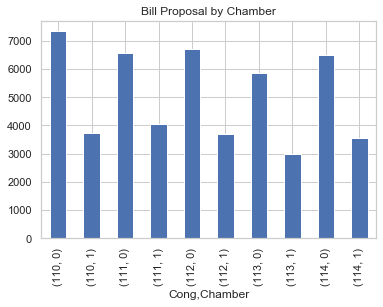

In [30]:
#Portion of bills proposed by the House and Senate
#0 for House, 1 for Senate
df.groupby(['Cong', 'Chamber']).size().plot.bar(stacked=True).set_title('Bill Proposal by Chamber')


Text(0.5, 1.0, 'Bill Proposal by Gender')

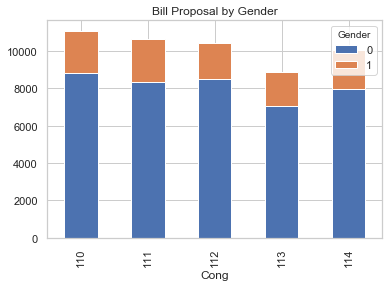

In [31]:
#All bills proposed in each congress, by Gender

df.groupby(['Cong', 'Gender']).size().unstack().plot.bar(stacked=True).set_title('Bill Proposal by Gender')


Text(0.5, 1.0, 'Bill Passage by Majority')

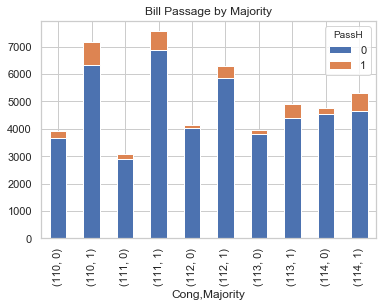

In [32]:
df.groupby(['Cong', 'Majority', 'PassH']).size().unstack().plot.bar(stacked=True).set_title('Bill Passage by Majority')


Text(0.5, 1.0, 'Bill Proposal by Party')

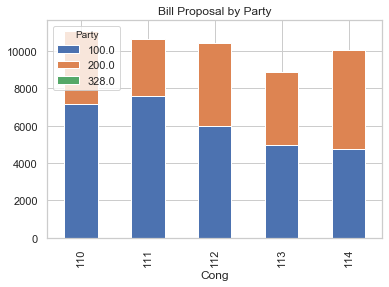

In [33]:
df.groupby(['Cong', 'Party']).size().unstack().plot.bar(stacked=True).set_title('Bill Proposal by Party')


Text(0.5, 1.0, 'Bill Proposal by Majority')

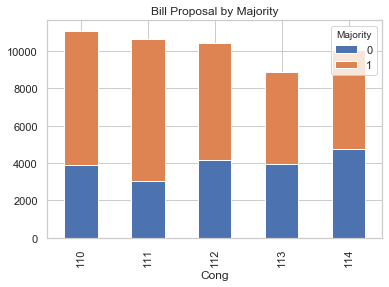

In [34]:
df.groupby(['Cong', 'Majority']).size().unstack().plot.bar(stacked=True).set_title('Bill Proposal by Majority')


Text(0.5, 1.0, 'Party breakdown by Congress')

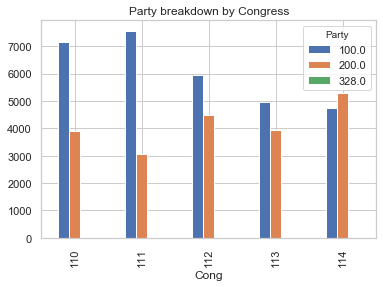

In [35]:
#Party code (100 Democrat; 200 Republican, 328…from ICPSR)
df.groupby(['Cong', 'Party']).size().unstack().plot.bar().set_title('Party breakdown by Congress')

**By State:**

.size includes NaN values, .count does not

Text(0.5, 1.0, 'Party breakdown by State')

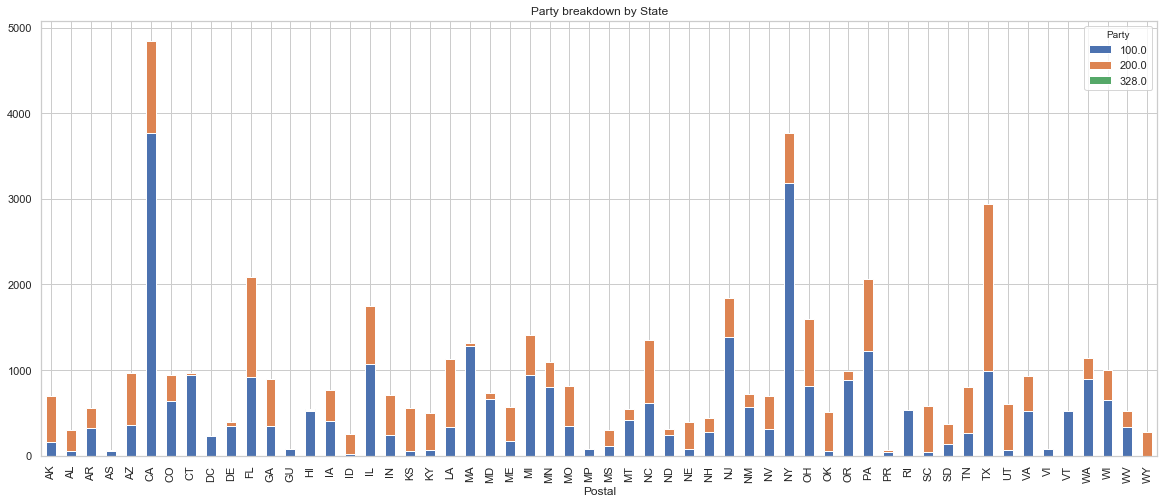

In [36]:
#Breakdown of bills proposed by party by state

df.groupby(['Postal', 'Party']).size().unstack().plot.bar(figsize=(20,8), stacked=True).set_title('Party breakdown by State')

Text(0.5, 1.0, 'Bill Passage by State')

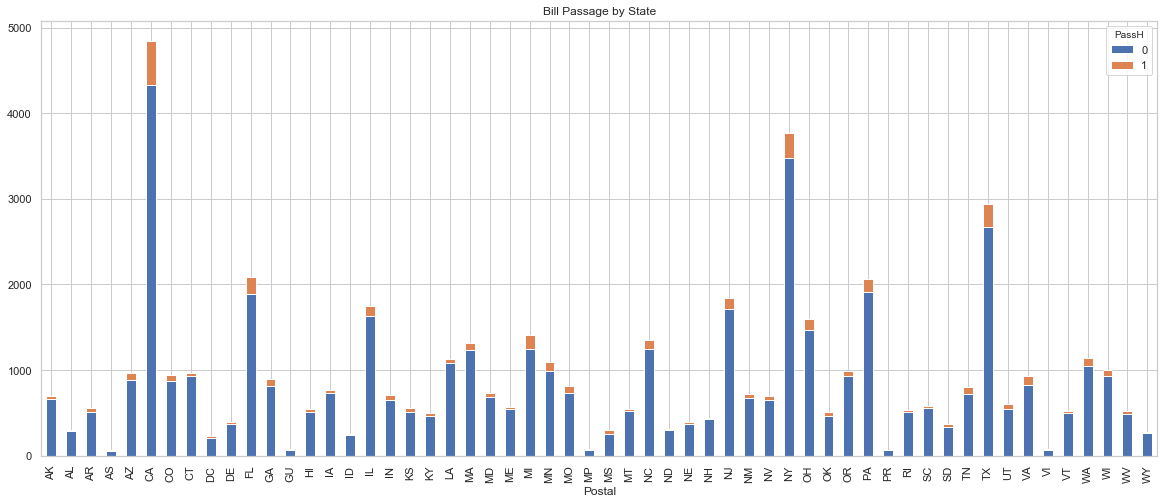

In [37]:
df.groupby(['Postal', 'PassH']).size().unstack().plot.bar(figsize=(20,8), stacked=True).set_title('Bill Passage by State')

Text(0.5, 1.0, 'Bill Passage by State')

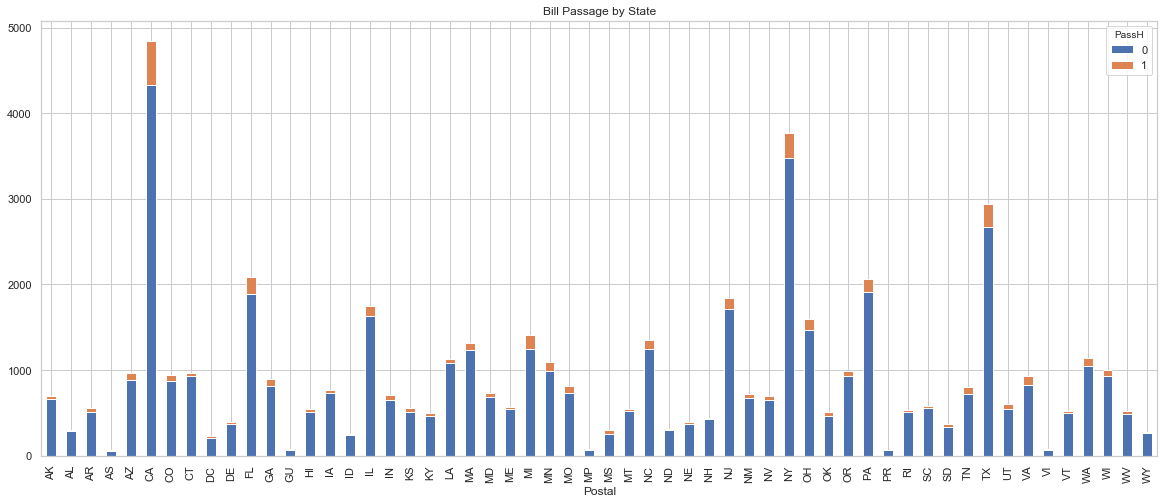

In [38]:
df.groupby(['Postal', 'PassH']).size().unstack().plot.bar(figsize=(20,8), stacked=True).set_title('Bill Passage by State')

Text(0.5, 1.0, 'Bill to Law Passage by State')

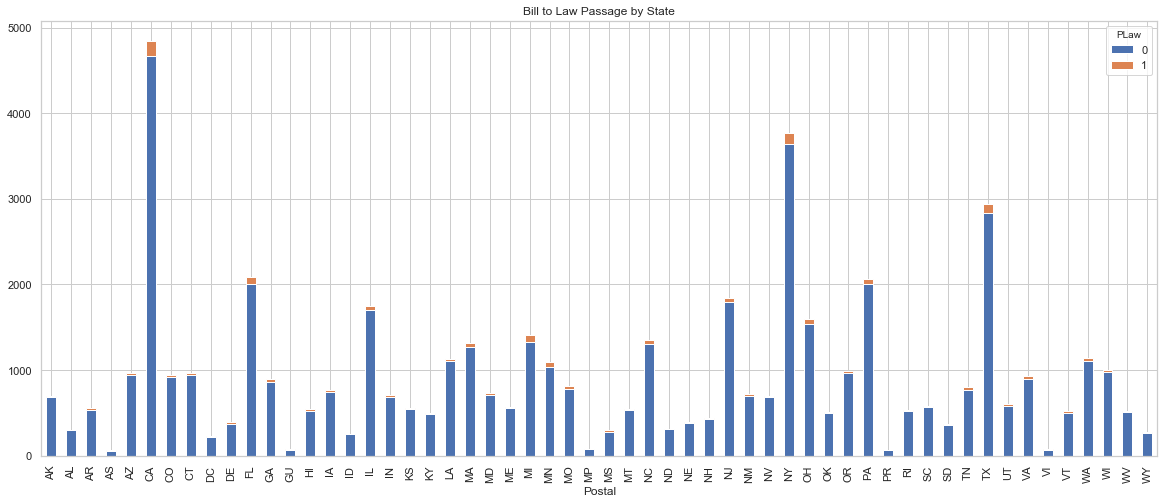

In [39]:
#Passed Laws by state. 0 is Not passed, 1 passed
df.groupby(['Postal', 'PLaw']).size().unstack().plot.bar(figsize=(20,8), stacked=True).set_title('Bill to Law Passage by State')

**NLP Graphs:**

Text(0.5, 1.0, 'Length of Title/Summary Text by Congress - Not Pass and Pass')

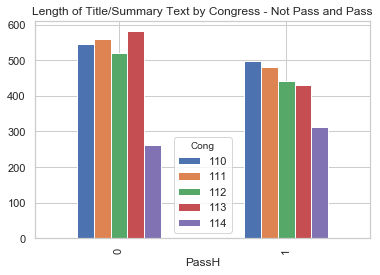

In [40]:
df.groupby(['PassH','Cong'])['text_len'].agg('mean').unstack().plot.bar().set_title('Length of Title/Summary Text by Congress - Not Pass and Pass')

Text(0.5, 1.0, 'Median Length of Title Text by Congress')

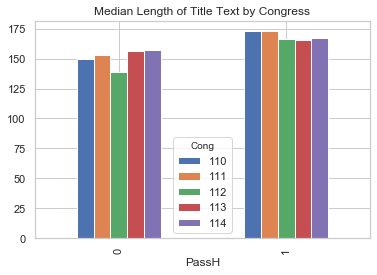

In [52]:
df.groupby(['PassH','Cong'])['title_len'].agg('median').unstack().plot.bar().set_title('Median Length of Title Text by Congress')

**EDA Passed Laws:**

In [41]:
#Bill vs number of Congresspersons - whip and majority or others?

In [64]:
df['NameFull'].value_counts().head()

Charles Schumer     477
Dianne Feinstein    452
Robert Casey        447
David Vitter        409
Robert Menendez     408
Name: NameFull, dtype: int64

In [56]:
from collections import Counter

all_names_dict = dict(Counter(df['NameFull']))

In [60]:
top_names = {key: value for key, value in all_names_dict.items() if value >= 100}


In [62]:
for name in sorted(top_names, key=top_names.get, reverse = True):
    print(name, top_names[name])

Charles Schumer 477
Dianne Feinstein 452
Robert Casey 447
David Vitter 409
Robert Menendez 408
Sherrod Brown 393
Ron Wyden 317
Amy Klobuchar 296
Barbara Boxer 295
John Kerry 287
Richard Durbin 285
Carolyn Maloney 267
Don Young 262
Kirsten Gillibrand 250
Edward Markey 242
Sheila Jackson Lee 233
Eleanor Norton 226
Lisa Murkowski 224
Orrin Hatch 219
Mary Landrieu 217
Jon Tester 214
Alan Grayson 214
Patrick Leahy 213
Jeff Bingaman 212
Carl Levin 210
John Rockefeller 209
Steve Israel 206
Benjamin Cardin 203
Patty Murray 203
Thomas Harkin 202
Charles Grassley 202
Frank Lautenberg 199
Max Baucus 199
Bill Nelson 199
Olympia Snowe 193
Kay Hagan 192
Maria Cantwell 191
Harry Reid 189
John Cornyn 189
John Reed 187
Bernard Sanders 185
John Conyers 184
Susan Collins 181
Mark Kirk 179
Ronald Paul 177
Richard Burr 176
Dean Heller 174
Bob Filner 172
James Inhofe 170
Rosa DeLauro 169
Jim McDermott 169
Mark Begich 164
Daniel Akaka 161
Earl Blumenauer 159
Richard Blumenthal 159
Mark Udall 158
Tom Udall 15